# Lecture 1: Course Introduction — Evidence and Uncertainty

**Data 145, Spring 2026**  
**Instructors:** Ani Adhikari, William Fithian

---

## What is this course about?

**How much can we rely on conclusions drawn from data?**

In Data 140, you learned how to build probabilistic models and compute quantities like expectations, variances, and distributions. In Data 100, you learned practical tools for data manipulation, visualization, and prediction.

This course bridges the gap: we develop the **mathematical foundations** for measuring uncertainty in statistical conclusions. When we estimate a parameter, how far off might we be? When we test a hypothesis, how confident should we be in the result? These questions require more than recipes — they require understanding *why* our methods work and *when* they might fail.

**Today's goal:** Work through a concrete example — estimating earthquake probabilities — to see why mathematical statistics matters. Along the way, we'll preview key themes of the course.

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('fivethirtyeight')
%matplotlib inline

# Color convention for the course:
# Blue (solid): Data and true distributions
# Red (dashed): Approximations (CLT, delta method, etc.)
COLOR_DATA = 'steelblue'
COLOR_APPROX = 'firebrick'

---

## The Question: How likely is a significant earthquake in California this week?

California is one of the most geologically active places on earth. Earthquake probability estimates inform:
- Emergency preparedness and resource allocation
- Public communication and risk perception
- Insurance pricing and building codes
- Infrastructure planning

This is personal for us! By the end of this semester, the UC Berkeley Statistics Department will have left its home of Evans Hall after *55 years* for the Data Gateway building — a building that might never have been built if Evans weren't seismically unsafe!

Today we'll try to gain a better understand of California earthquake patterns using real data from the **USGS earthquake catalog**. There are a variety of interesting questions we could ask about earthquakes:
- What is the chance of an earthquake in California in the next week?
- On average, how many earthquakes can we expect in the next month?
- What is the 90th percentile of the number of earthquakes over the next year?

Today we'll focus on answering the the first question today. Along the way, we'll discover that the *mathematical approach* we take matters because it affects both the precision and reliability of our estimates. 

---

### The Evidence: USGS earthquake catalog

We'll analyze earthquakes of magnitude 4.0 or greater in California from 1980 to 2025. The data comes from the USGS ComCat catalog, with aftershocks removed using the Gardner-Knopoff (1974) declustering algorithm (non-aftershock quakes are called "mainshocks"). Technical details are in the course materials.


In [82]:
# Load the earthquake data
earthquakes = pd.read_csv('../../demos/lec01_earthquakes/data/california_earthquakes_declustered.csv')
earthquakes['time'] = pd.to_datetime(earthquakes['time'], format='ISO8601')

# Filter to mainshocks with M >= 4.0
mainshocks = earthquakes[(earthquakes['is_mainshock']) & (earthquakes['mag'] >= 4.0)].copy()
mainshocks = mainshocks.sort_values('time').reset_index(drop=True)

print(f"California M >= 4.0 mainshocks: {len(mainshocks)}")
print(f"Date range: {mainshocks['time'].min().date()} to {mainshocks['time'].max().date()}")

# Total time span in years
total_days = (mainshocks['time'].max() - mainshocks['time'].min()).days
total_years = total_days / 365.25
print(f"Time span: {total_years:.1f} years ({total_days} days)")

California M >= 4.0 mainshocks: 614
Date range: 1980-01-24 to 2025-12-14
Time span: 45.9 years (16761 days)


### Interarrival Times

The key quantity for our analysis is the **interarrival time** — the time between consecutive earthquakes. If we can model the distribution of interarrival times, we can answer questions like "what's the probability of an earthquake within the next week?"

In [83]:
# Compute interarrival times (in days)
interarrivals = mainshocks['time'].diff().dt.total_seconds() / (60 * 60 * 24)
interarrivals = interarrivals.dropna().values

n = len(interarrivals)
mean_interarrival = np.mean(interarrivals)

print(f"Number of interarrival times: {n}")
print(f"Mean interarrival time: {mean_interarrival:.1f} days")
print(f"That's about one M >= 4.0 earthquake every {mean_interarrival/7:.1f} weeks")

Number of interarrival times: 613
Mean interarrival time: 27.3 days
That's about one M >= 4.0 earthquake every 3.9 weeks


### Visualizing the Data

Let's look at the interarrival times. What do you notice about the distribution?

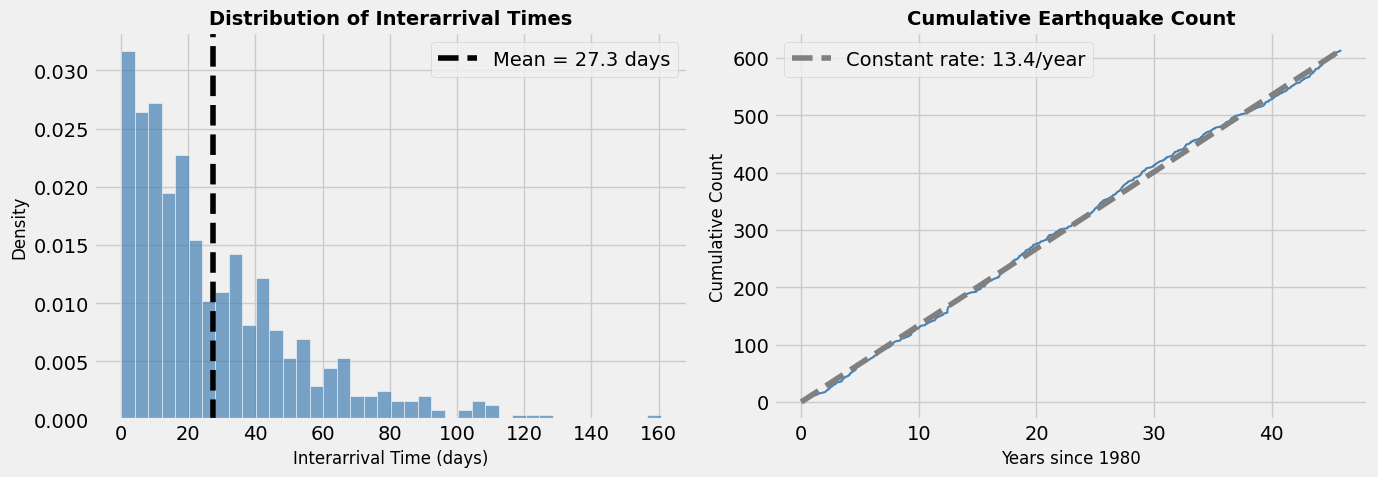

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of interarrival times
axes[0].hist(interarrivals, bins=40, density=True, color=COLOR_DATA, 
             alpha=0.7, edgecolor='white')
axes[0].set_xlabel('Interarrival Time (days)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Distribution of Interarrival Times', fontsize=14, fontweight='bold')
axes[0].axvline(mean_interarrival, color='black', linestyle='--', 
                label=f'Mean = {mean_interarrival:.1f} days')
axes[0].legend()

# Right: Cumulative count over time (check for constant rate)
times = (mainshocks['time'] - mainshocks['time'].min()).dt.days.values
counts = np.arange(1, len(mainshocks) + 1)

axes[1].plot(times / 365.25, counts, color=COLOR_DATA, linewidth=1.5)
axes[1].set_xlabel('Years since 1980', fontsize=12)
axes[1].set_ylabel('Cumulative Count', fontsize=12)
axes[1].set_title('Cumulative Earthquake Count', fontsize=14, fontweight='bold')

# Add reference line for constant rate
rate = len(mainshocks) / (total_days / 365.25)
axes[1].plot([0, total_years], [0, len(mainshocks)], '--', color='gray',
             label=f'Constant rate: {rate:.1f}/year')
axes[1].legend()

plt.tight_layout()
plt.show()

### First Observations

1. **Right-skewed histogram**: Many short waits, some long ones. This is characteristic of the exponential distribution.

2. **Roughly linear cumulative count**: The earthquakes arrive at approximately a constant rate over time.

These observations suggest a natural statistical model: the **Poisson process**.

---

## Part 3: The Poisson Process Model

### Model Assumptions

A **homogeneous Poisson process** with rate $\lambda$ assumes:
1. Events occur at a constant rate $\lambda$ (events per unit time)
2. Events in non-overlapping intervals are independent
3. Two events cannot occur at exactly the same time

**Key consequence:** If events follow a Poisson process with rate $\lambda$, then the interarrival times $X_1, X_2, \ldots, X_n$ are **i.i.d. Exponential($\lambda$)**.

The exponential distribution has density:
$$f(x) = \lambda e^{-\lambda x}, \quad x > 0$$

with mean $E[X] = 1/\lambda$ and variance $\text{Var}(X) = 1/\lambda^2$.

### The Power of Parametric Models

Notice what's happened: we've reduced an infinite-dimensional problem (the entire distribution of interarrival times) to a **single parameter** $\lambda$. If the model is correct, knowing $\lambda$ tells us *everything* about the distribution.

### Maximum Likelihood Estimation

Given i.i.d. observations $X_1, \ldots, X_n \sim \text{Exponential}(\lambda)$, the likelihood function is:

$$L(\lambda) = \prod_{i=1}^n \lambda e^{-\lambda X_i} = \lambda^n \exp\left(-\lambda \sum_{i=1}^n X_i\right)$$

Taking logs:
$$\ell(\lambda) = n \log \lambda - \lambda \sum_{i=1}^n X_i$$

Setting the derivative to zero:
$$\frac{d\ell}{d\lambda} = \frac{n}{\lambda} - \sum_{i=1}^n X_i = 0$$

Solving for $\lambda$:
$$\boxed{\hat{\lambda} = \frac{n}{\sum_{i=1}^n X_i} = \frac{1}{\overline{X}_n}}$$

The MLE of the rate is the reciprocal of the sample mean.

In [85]:
# Compute the MLE
lambda_hat = 1 / mean_interarrival

print(f"MLE of rate: λ̂ = {lambda_hat:.4f} per day")
print(f"            = {lambda_hat * 7:.3f} per week")
print(f"            = {lambda_hat * 365.25:.1f} per year")

MLE of rate: λ̂ = 0.0366 per day
            = 0.256 per week
            = 13.4 per year


### Does the Model Fit? The Memoryless Property

The exponential distribution has a distinctive **memoryless property**: the conditional distribution of the remaining wait time, given that you've already waited a while, is the same as the original distribution.

Mathematically: if $X \sim \text{Exponential}(\lambda)$, then for any $s > 0$:
$$(X - s) \mid X > s \sim \text{Exponential}(\lambda)$$

This is a strong assumption! It says that if a week has passed without an earthquake, the distribution of additional waiting time is the same as if we'd just started waiting.

Let's check this graphically by comparing:
- The original distribution of interarrival times
- The conditional distribution of $(X - 7)$ given $X > 7$ (the "residual" wait after one week)

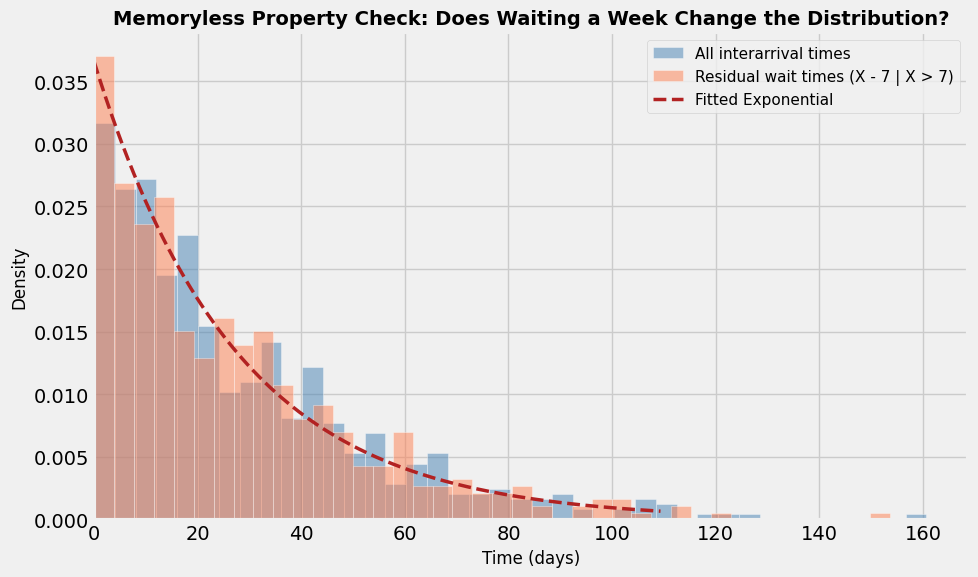

Of 613 interarrival times, 485 (79%) were longer than 7 days.
The residual distribution (coral) closely matches the original (blue) — memoryless property holds!


In [86]:
# Check the memoryless property graphically
fig, ax = plt.subplots(figsize=(10, 6))

# Original interarrivals
ax.hist(interarrivals, bins=40, density=True, alpha=0.5, color=COLOR_DATA,
        edgecolor='white', label='All interarrival times')

# Conditional: (X - 7) | X > 7
residuals = interarrivals[interarrivals > 7] - 7
ax.hist(residuals, bins=40, density=True, alpha=0.5, color='coral',
        edgecolor='white', label='Residual wait times (X - 7 | X > 7)')

# Fitted exponential for reference
x_grid = np.linspace(0, np.percentile(interarrivals, 99), 200)
ax.plot(x_grid, lambda_hat * np.exp(-lambda_hat * x_grid), '--',
        color=COLOR_APPROX, linewidth=2.5, label='Fitted Exponential')

ax.set_xlabel('Time (days)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Memoryless Property Check: Does Waiting a Week Change the Distribution?',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xlim(0, None)

plt.tight_layout()
plt.show()

n_after_week = len(residuals)
print(f"Of {n} interarrival times, {n_after_week} ({100*n_after_week/n:.0f}%) were longer than 7 days.")
print(f"The residual distribution (coral) closely matches the original (blue) — memoryless property holds!")

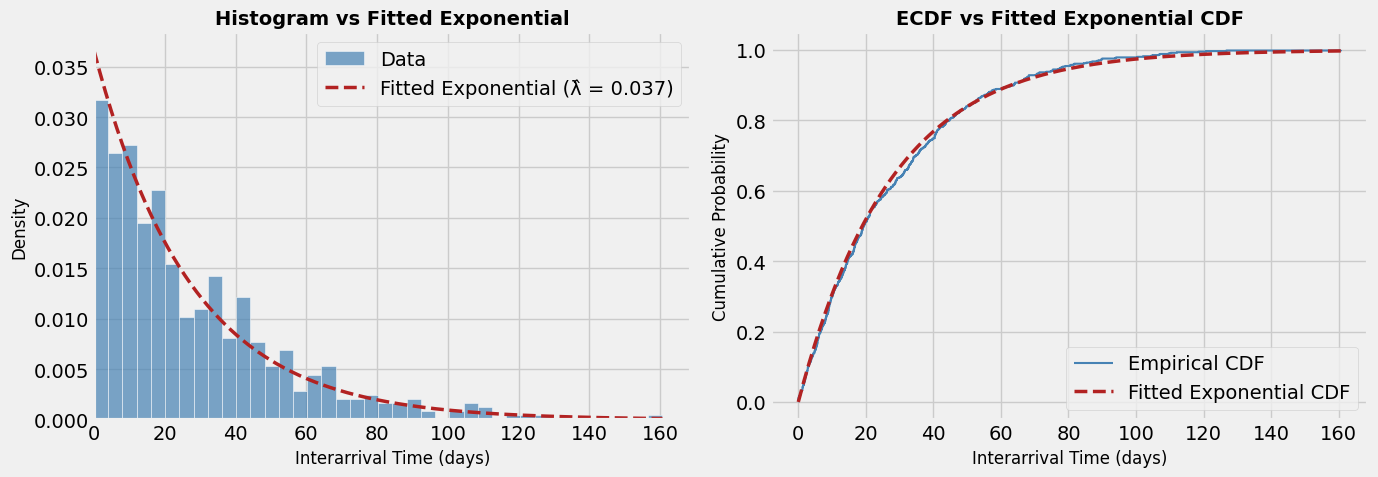

In [87]:
# Compare histogram to fitted exponential
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram with fitted density
x_grid = np.linspace(0, max(interarrivals), 300)
fitted_density = lambda_hat * np.exp(-lambda_hat * x_grid)

axes[0].hist(interarrivals, bins=40, density=True, color=COLOR_DATA, 
             alpha=0.7, edgecolor='white', label='Data')
axes[0].plot(x_grid, fitted_density, '--', color=COLOR_APPROX, linewidth=2.5,
             label=f'Fitted Exponential (λ̂ = {lambda_hat:.3f})')
axes[0].set_xlabel('Interarrival Time (days)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Histogram vs Fitted Exponential', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, None)

# Right: Empirical CDF vs Fitted CDF
sorted_data = np.sort(interarrivals)
ecdf = np.arange(1, n + 1) / n
fitted_cdf = 1 - np.exp(-lambda_hat * x_grid)

axes[1].step(sorted_data, ecdf, where='post', color=COLOR_DATA, 
             linewidth=1.5, label='Empirical CDF')
axes[1].plot(x_grid, fitted_cdf, '--', color=COLOR_APPROX, linewidth=2.5,
             label='Fitted Exponential CDF')
axes[1].set_xlabel('Interarrival Time (days)', fontsize=12)
axes[1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1].set_title('ECDF vs Fitted Exponential CDF', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

The exponential model appears to fit the data reasonably well. We'll learn formal goodness-of-fit tests (like the Kolmogorov-Smirnov test) in a few weeks.

### The Uncertainty: How accurate is our rate estimate?

Since our data set is noisy, we'd like to get some idea of the sampling distribution of our estimator for the rate parameter. We'll use a standard bootstrap to resample the interarrival times and compute $\hat{\lambda}$ for each resample.


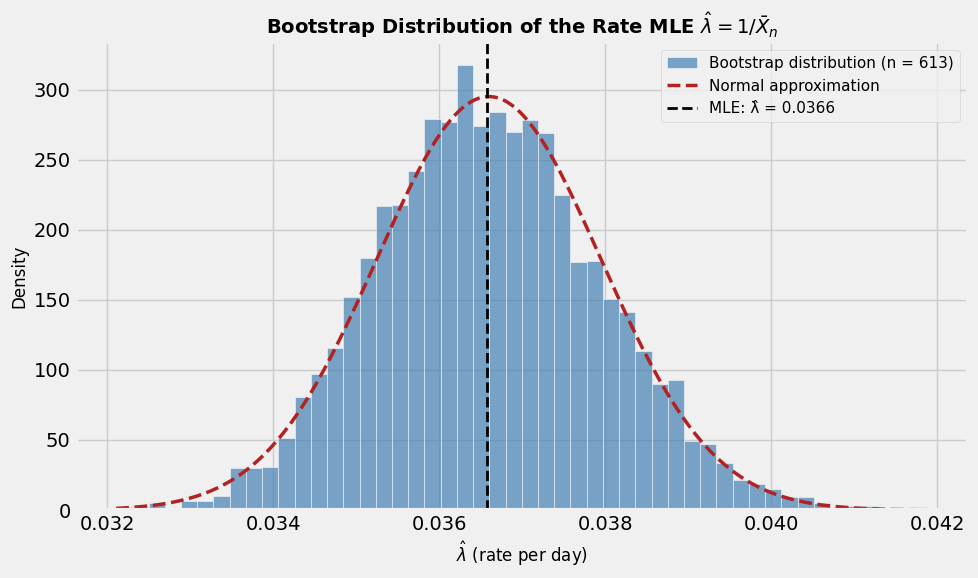

Bootstrap mean: 0.0366
Bootstrap std:  0.0014

The rate MLE is approximately normal — this is the delta method in action!


In [88]:
# Bootstrap the rate MLE
n_bootstrap = 5000
np.random.seed(42)

boot_lambda = np.zeros(n_bootstrap)
for b in range(n_bootstrap):
    boot_sample = np.random.choice(interarrivals, size=n, replace=True)
    boot_lambda[b] = 1 / np.mean(boot_sample)

# Plot the bootstrap distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(boot_lambda, bins=50, density=True, color=COLOR_DATA, alpha=0.7, edgecolor='white',
        label=f'Bootstrap distribution (n = {n})')

# Overlay normal approximation
boot_mean = np.mean(boot_lambda)
boot_std = np.std(boot_lambda)
x_grid = np.linspace(boot_lambda.min(), boot_lambda.max(), 200)
ax.plot(x_grid, stats.norm.pdf(x_grid, boot_mean, boot_std), '--', color=COLOR_APPROX,
        linewidth=2.5, label=f'Normal approximation')

ax.axvline(lambda_hat, color='black', linestyle='--', linewidth=2, label=f'MLE: λ̂ = {lambda_hat:.4f}')

ax.set_xlabel(r'$\hat{\lambda}$ (rate per day)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(r'Bootstrap Distribution of the Rate MLE $\hat{\lambda} = 1/\overline{X}_n$',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"Bootstrap mean: {boot_mean:.4f}")
print(f"Bootstrap std:  {boot_std:.4f}")
print(f"\nThe rate MLE is approximately normal — this is the delta method in action!")

Perhaps surprisingly, the bootstrap histogram looks very close to a normal fit. Why should that be?

By the **CLT**, the *sample mean* $\overline{X}_n$ is approximately normal for large $n$. But $\hat{\lambda} = 1/\overline{X}_n$ is a *nonlinear function* of the sample mean. Why should it be approximately normal? We'll investigate this near the end of the lecture.

---

## Back to our question

We now return to our original question: what's the probability of an earthquake within 7 days?

If $X \sim \text{Exponential}(\lambda)$, then:
$$P(X \le t) = 1 - e^{-\lambda t}$$

We can plot this function below for a range of $\lambda$ values:

This is a one-to-one (increasing) function of the rate parameter $\lambda$, so we could just think of it as a different way of parameterizing the model. So we can get the MLE for that probability by plugging $\hat{\lambda}$ into our formula:
$$\hat{P}(X \le 7) = 1 - e^{-\hat{\lambda} \cdot 7}$$

In [90]:
t = 7  # days

# MLE-based probability estimate
p_mle = 1 - np.exp(-lambda_hat * t)

print(f"Estimated probability of M >= 4.0 earthquake within {t} days:")
print(f"  P̂(X ≤ {t}) = 1 - exp(-{lambda_hat:.4f} × {t}) = {p_mle:.3f} ({100*p_mle:.1f}%)")

Estimated probability of M >= 4.0 earthquake within 7 days:
  P̂(X ≤ 7) = 1 - exp(-0.0366 × 7) = 0.226 (22.6%)


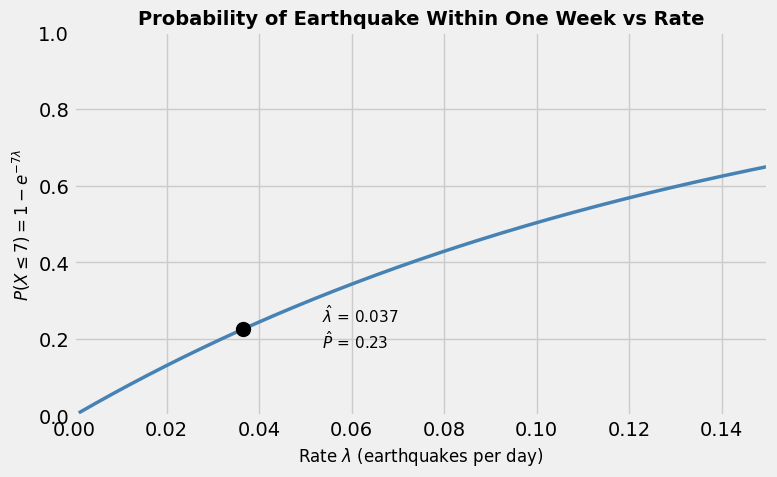

In [89]:
# Plot the function from λ to P(earthquake within 7 days)
fig, ax = plt.subplots(figsize=(8, 5))

lambda_grid = np.linspace(0.001, 0.15, 200)
prob_grid = 1 - np.exp(-lambda_grid * 7)

ax.plot(lambda_grid, prob_grid, color=COLOR_DATA, linewidth=2.5)

# Mark our MLE estimate
ax.plot(lambda_hat, p_mle, 'ko', markersize=10, zorder=5)
ax.annotate(f'  $\\hat{{\\lambda}}$ = {lambda_hat:.3f}\n  $\\hat{{P}}$ = {p_mle:.2f}',
            xy=(lambda_hat, p_mle), fontsize=11,
            xytext=(lambda_hat + 0.015, p_mle - 0.05))

ax.set_xlabel(r'Rate $\lambda$ (earthquakes per day)', fontsize=12)
ax.set_ylabel(r'$P(X \leq 7) = 1 - e^{-7\lambda}$', fontsize=12)
ax.set_title('Probability of Earthquake Within One Week vs Rate', fontsize=14, fontweight='bold')
ax.set_xlim(0, 0.15)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### An Alternative Approach: Just Count!

But wait — do we need all this machinery? We could just compute the **empirical proportion** of interarrival times that were 7 days or less:

$$\hat{p}_{\text{Obs}} = \frac{1}{n} \sum_{i=1}^n \mathbf{1}(X_i \le 7)$$

In [91]:
# Empirical CDF estimate
p_obs = np.mean(interarrivals <= t)

print(f"Two estimates of P(earthquake within {t} days):\n")
print(f"  Empirical (just count):  {p_obs:.3f} ({100*p_obs:.1f}%)")
print(f"  MLE-based (fit model):   {p_mle:.3f} ({100*p_mle:.1f}%)")

Two estimates of P(earthquake within 7 days):

  Empirical (just count):  0.209 (20.9%)
  MLE-based (fit model):   0.226 (22.6%)


The estimates are similar. But which one is *better*? By "better," we mean: which has lower sampling variability? Which would give more consistent answers if we repeated the data collection?

This is a question about the **sampling distributions** of the two estimators.

---

## Comparing Sampling Variability

To understand how variable these estimators are, we'll use the **bootstrap**: resample from our data with replacement, and see how much the estimates vary.

This simulates what would happen if we collected new data from the same underlying process.

In [98]:
# Bootstrap comparison
n_boot_size = len(interarrivals)  # Use full sample size
n_bootstrap = 5000

np.random.seed(42)

boot_obs = np.zeros(n_bootstrap)
boot_mle = np.zeros(n_bootstrap)

for b in range(n_bootstrap):
    # Resample with replacement
    boot_sample = np.random.choice(interarrivals, size=n_boot_size, replace=True)
    
    # Observed proportion
    boot_obs[b] = np.mean(boot_sample <= t)
    
    # MLE-based estimate
    lambda_boot = 1 / np.mean(boot_sample)
    boot_mle[b] = 1 - np.exp(-lambda_boot * t)

print(f"Bootstrap results (n = {n_boot_size}, {n_bootstrap} resamples):\n")
print(f"{'Estimator':<20} {'Mean':>10} {'Std':>10}")
print("-" * 42)
print(f"{'Observed proportion':<20} {np.mean(boot_obs):>10.4f} {np.std(boot_obs):>10.4f}")
print(f"{'MLE-based (model)':<20} {np.mean(boot_mle):>10.4f} {np.std(boot_mle):>10.4f}")
print()
print(f"Standard deviation ratio (Obs / MLE): {np.std(boot_obs) / np.std(boot_mle):.2f}")
print(f"Variance ratio: {np.var(boot_obs) / np.var(boot_mle):.2f}")

In [99]:
# Visualize the bootstrap distributions
fig, ax = plt.subplots(figsize=(10, 6))

# Create appropriate bins for discrete observed proportion values
k_min = int(np.floor(boot_obs.min() * n_boot_size))
k_max = int(np.ceil(boot_obs.max() * n_boot_size))
obs_bins = (np.arange(k_min, k_max + 2) - 0.5) / n_boot_size

# Bins for continuous MLE values
mle_bins = np.linspace(boot_mle.min(), boot_mle.max(), 50)

ax.hist(boot_obs, bins=obs_bins, alpha=0.6, color='coral', density=True,
        label=f'Observed proportion (std = {np.std(boot_obs):.4f})')
ax.hist(boot_mle, bins=mle_bins, alpha=0.6, color=COLOR_DATA, density=True,
        label=f'MLE-based (std = {np.std(boot_mle):.4f})')

ax.axvline(p_obs, color='darkred', linestyle='--', linewidth=2, alpha=0.8,
           label=f'Sample estimate $\hat{{p}}_{{\mathrm{{Obs}}}}$ = {p_obs:.3f}')
ax.axvline(p_mle, color='darkblue', linestyle='--', linewidth=2, alpha=0.8,
           label=f'Sample estimate $\hat{{p}}_{{\mathrm{{MLE}}}}$ = {p_mle:.3f}')

ax.set_xlabel('Estimated Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Bootstrap Sampling Distributions (n = {n_boot_size})', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

### Key Observation

**Both estimators are approximately Gaussian, but the MLE-based estimator has lower variance!**

The variance ratio is about 5× — meaning the MLE-based estimator's variance is roughly 1/5 of the empirical estimator's variance.

### What Does a 5× Variance Reduction Mean?

For two normal estimators of the same quantity, **a 5× reduction in variance is equivalent to quintupling the sample size**.

Here's why: if $\hat{\theta}_1$ has variance $\sigma^2/n$, you'd need $5n$ observations to get the same precision with $\hat{\theta}_2$ if it has variance $5\sigma^2/n$.

So using the MLE-based estimator with $n = 613$ observations gives us about the same precision as using the empirical proportion with $n \approx 3000$ observations.

### Why the Difference?

**Empirical proportion**: For each observation $X_i$, we only use the binary information "was $X_i \le 7$ or not?" The actual value of $X_i$ is thrown away.

**MLE-based**: Uses the actual value of every $X_i$ to estimate $\lambda$, then transforms to get the probability. As we'll come to understand later, this model's mathematical structure means that $\overline{X}_n$ is the *best possible summary* of the entire dataset (for other models, another way of summarizing the data might be better).

**If the exponential model is correct**, knowing $\lambda$ tells us *everything* about the distribution. Estimating $\lambda$ well (using all the data) lets us estimate any probability well.

### The Gain Is Even Larger for Rarer Events

The efficiency advantage of the MLE-based estimator depends on how much information is "wasted" by the empirical approach. For probabilities near 0.5, the empirical proportion doesn't waste much, but it is extremely wasteful for estimating rare events (small probabilities), where the vast majority of $X_i$ values are above $t$.

Let's see this by repeating the analysis for **M ≥ 5.0** earthquakes, which are much rarer than M ≥ 4.0.

In [94]:
# Repeat analysis for M >= 5.0 earthquakes
mainshocks_5 = earthquakes[(earthquakes['is_mainshock']) & (earthquakes['mag'] >= 5.0)].copy()
mainshocks_5 = mainshocks_5.sort_values('time').reset_index(drop=True)

interarrivals_5 = mainshocks_5['time'].diff().dt.total_seconds() / (60 * 60 * 24)
interarrivals_5 = interarrivals_5.dropna().values

n_5 = len(interarrivals_5)
lambda_hat_5 = 1 / np.mean(interarrivals_5)

print(f"M >= 5.0 mainshocks: {len(mainshocks_5)}")
print(f"Mean interarrival time: {np.mean(interarrivals_5):.1f} days")
print(f"Rate: {lambda_hat_5:.4f} per day ({lambda_hat_5 * 365.25:.1f} per year)")

M >= 5.0 mainshocks: 81
Mean interarrival time: 206.5 days
Rate: 0.0048 per day (1.8 per year)


In [ ]:
# Bootstrap comparison for M >= 5.0
t = 7
n_bootstrap = 5000
np.random.seed(42)

boot_obs_5 = np.zeros(n_bootstrap)
boot_mle_5 = np.zeros(n_bootstrap)

for b in range(n_bootstrap):
    boot_sample = np.random.choice(interarrivals_5, size=n_5, replace=True)
    boot_obs_5[b] = np.mean(boot_sample <= t)
    lambda_boot = 1 / np.mean(boot_sample)
    boot_mle_5[b] = 1 - np.exp(-lambda_boot * t)

print(f"M >= 5.0 Bootstrap results (n = {n_5}):\n")
print(f"{'Estimator':<20} {'Mean':>10} {'Std':>10}")
print("-" * 42)
print(f"{'Observed proportion':<20} {np.mean(boot_obs_5):>10.4f} {np.std(boot_obs_5):>10.4f}")
print(f"{'MLE-based (model)':<20} {np.mean(boot_mle_5):>10.4f} {np.std(boot_mle_5):>10.4f}")
print()
print(f"Variance ratio: {np.var(boot_obs_5) / np.var(boot_mle_5):.1f}×")
print(f"\nCompare to M >= 4.0 variance ratio: {np.var(boot_obs) / np.var(boot_mle):.1f}×")
print(f"\nThe rarer the event, the more the MLE-based approach helps!")

In [96]:
# Visualize M >= 5.0 bootstrap distributions
fig, ax = plt.subplots(figsize=(10, 6))

# Obs bins
k_min = int(np.floor(boot_obs_5.min() * n_5))
k_max = int(np.ceil(boot_obs_5.max() * n_5))
obs_bins = (np.arange(k_min, k_max + 2) - 0.5) / n_5

# MLE bins
mle_bins = np.linspace(boot_mle_5.min(), boot_mle_5.max(), 50)

ax.hist(boot_obs_5, bins=obs_bins, alpha=0.6, color='coral', density=True,
        label=f'Observed proportion (std = {np.std(boot_obs_5):.4f})')
ax.hist(boot_mle_5, bins=mle_bins, alpha=0.6, color=COLOR_DATA, density=True,
        label=f'MLE-based (std = {np.std(boot_mle_5):.4f})')

# Add vertical lines for sample estimates
p_obs_5 = np.mean(interarrivals_5 <= t)
p_mle_5 = 1 - np.exp(-lambda_hat_5 * t)
ax.axvline(p_obs_5, color='darkred', linestyle='--', linewidth=2, alpha=0.8,
           label=f'Sample estimate $\hat{{p}}_{{\mathrm{{Obs}}}}$ = {p_obs_5:.3f}')
ax.axvline(p_mle_5, color='darkblue', linestyle='--', linewidth=2, alpha=0.8,
           label=f'Sample estimate $\hat{{p}}_{{\mathrm{{MLE}}}}$ = {p_mle_5:.3f}')

ax.set_xlabel('Estimated Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'M ≥ 5.0: Bootstrap Sampling Distributions (n = {n_5})',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

---

## Delta method: Why are the MLE-based etimates normal?

All three of the estimators we've seen ($\hat\lambda$, and both $\hat p_{\text{MLE}}$ and $\hat p_{\text{Obs}}$ are approximately Gaussian. This makes sense for the empirical proportion $\hat p_{\text{Obs}}$: it's a sample mean of binary indicators, so the CLT applies directly.

But what about the MLE-based estimators $\hat\lambda$ and $\hat{p}_{\text{MLE}}$? It's a **nonlinear function** of $\overline{X}_n$:

$$\hat{p}_{\text{MLE}} = g(\overline{X}_n) \quad \text{where} \quad g(x) = 1 - e^{-t/x}$$

Why should a nonlinear function of a normal be approximately normal?

### The Delta Method (Intuition)

Three key facts combine:

1. **$\overline{X}_n$ is approximately normal** (by CLT) with mean $\mu = E[X] = 1/\lambda$ and small standard deviation $\sigma/\sqrt{n}$.

2. **For large $n$, $\overline{X}_n$ is concentrated** near its mean. Almost all the probability is within a few standard deviations, and the standard deviation shrinks like $1/\sqrt{n}$.

3. **Smooth functions are locally linear.** Over a small interval, any smooth function $g$ is well-approximated by its tangent line.

Putting these together: the function $g$ looks linear over the range where $\overline{X}_n$ actually lives. And a linear function of a normal is still normal!

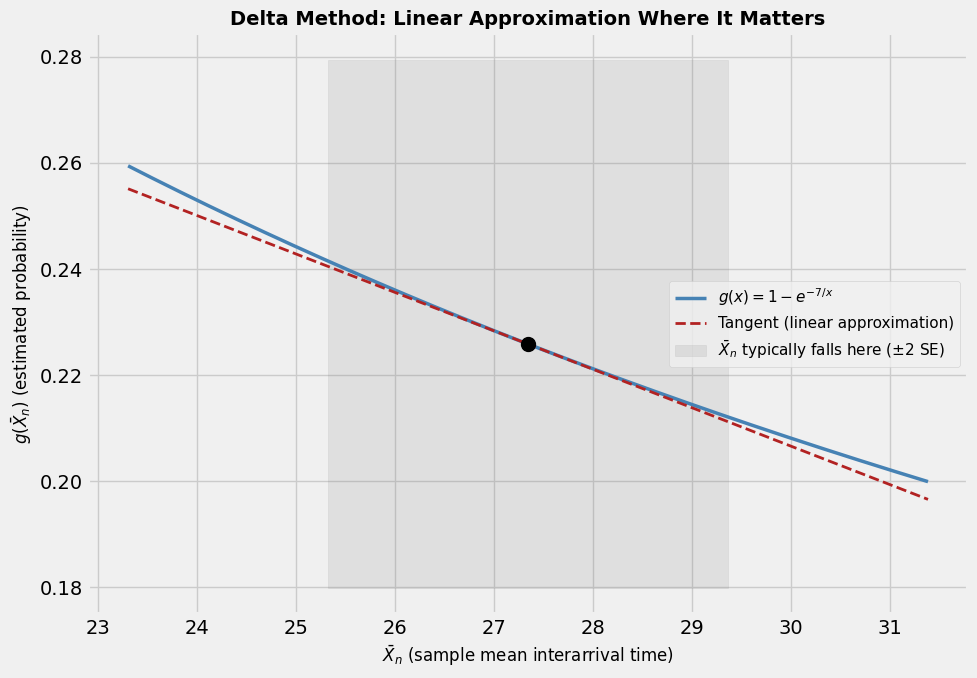

Over the shaded region, the function and tangent are nearly indistinguishable!
A linear function of a normal is still normal.


In [97]:
# Visualize the delta method intuition
def g(x, t=7):
    """The probability transformation: g(x) = 1 - exp(-t/x)"""
    return 1 - np.exp(-t / x)

def g_deriv(x, t=7):
    """Derivative: g'(x) = -(t/x^2) * exp(-t/x)"""
    return -(t / x**2) * np.exp(-t / x)

# True values
true_mean = 1 / lambda_hat  # = mean_interarrival
true_output = g(true_mean)

# Range to plot (±3 standard deviations of X-bar)
xbar_std = np.std(interarrivals) / np.sqrt(n)
x_min = true_mean - 4 * xbar_std
x_max = true_mean + 4 * xbar_std
x_grid = np.linspace(x_min, x_max, 200)

# The function g
y_grid = g(x_grid)

# Tangent line at true_mean
slope = g_deriv(true_mean)
tangent = true_output + slope * (x_grid - true_mean)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot the function (blue solid)
ax.plot(x_grid, y_grid, '-', color=COLOR_DATA, linewidth=2.5, label=r'$g(x) = 1 - e^{-7/x}$')

# Plot the tangent line (red dashed)
ax.plot(x_grid, tangent, '--', color=COLOR_APPROX, linewidth=2, 
        label='Tangent (linear approximation)')

# Mark the point of tangency
ax.plot(true_mean, true_output, 'ko', markersize=10, zorder=5)

# Shade the region where X-bar typically falls
x_shade = np.linspace(true_mean - 2*xbar_std, true_mean + 2*xbar_std, 50)
ax.fill_betweenx([g(x_grid).min() - 0.02, g(x_grid).max() + 0.02], 
                 true_mean - 2*xbar_std, true_mean + 2*xbar_std,
                 alpha=0.15, color='gray', label=r'$\overline{X}_n$ typically falls here (±2 SE)')

ax.set_xlabel(r'$\overline{X}_n$ (sample mean interarrival time)', fontsize=12)
ax.set_ylabel(r'$g(\overline{X}_n)$ (estimated probability)', fontsize=12)
ax.set_title('Delta Method: Linear Approximation Where It Matters', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"Over the shaded region, the function and tangent are nearly indistinguishable!")
print(f"A linear function of a normal is still normal.")

### The Delta Method (Preview)

If $\overline{X}_n$ is approximately $N(\mu, \sigma^2/n)$ and $g$ is smooth with $g'(\mu) \ne 0$, then:

$$g(\overline{X}_n) \approx N\left(g(\mu), \, [g'(\mu)]^2 \cdot \frac{\sigma^2}{n}\right)$$

The variance of the transformed estimator is the original variance times the squared derivative.

We'll make this precise — with careful statements about convergence — in Lecture 2.

---

## More Questions We Can Now Ask

Today's example raises several natural questions that we'll address throughout the course:

| Question | Course Topic |
|----------|-------------|
| **How far off is our estimate? Can we get a confidence interval?** | Delta method, standard errors (Lecture 2) |
| **How do we formally check if the exponential model fits?** | Goodness-of-fit testing, KS test (Worksheet 1, Lecture 11) |
| **What if the model is wrong?** | Model misspecification, robustness (Lecture 9) |
| **Why is the MLE a good choice? Could we do better?** | MLE theory, efficiency (Lectures 3-5) |
| **What's the Bayesian perspective on this problem?** | Prior/posterior, credible intervals (Lectures 6-8) |

---

## Preview of Lecture 2

Next time, we'll make the delta method precise:

- **Modes of convergence**: What does it mean for random variables to "converge"?
- **Continuous mapping theorem**: If $X_n \to X$ and $g$ is continuous, then $g(X_n) \to g(X)$
- **Slutsky's theorem**: Rules for combining converging sequences
- **Delta method**: The formal statement and proof

These tools form the foundation for much of what we'll do in the first half of the course.

---

## Summary

1. **Real question**: How likely is an earthquake this week?

2. **Parametric model**: The Poisson process reduces an infinite-dimensional problem to one parameter $\lambda$.

3. **MLE**: $\hat{\lambda} = 1/\overline{X}_n$ — the reciprocal of the sample mean.

4. **Two estimators for P(earthquake within 7 days)**: Empirical proportion vs. MLE-based. Both are approximately Gaussian, but the MLE-based estimator has lower variance.

5. **Why Gaussian?** The empirical proportion is a mean of indicators (CLT). The MLE-based estimator is a smooth function of a mean (delta method).

6. **The delta method** explains why smooth functions of normal random variables remain approximately normal — and tells us how to compute the variance.